In [7]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [8]:
df = pd.read_csv('../datasets/diamond_pricing.csv')
df.head()

,Paleonium,Pressure,Price
0,17,6567,2810.280298
1,59,5253,1986.967089
2,123,9715,2083.132087
3,182,2073,2236.340285
4,133,6400,1903.323339


In [9]:
x = df[['Paleonium','Pressure']]
y = df['Price']

In [10]:
import xgboost as xgb

In [11]:
trainx, testx, trainy, testy = train_test_split(x,y,random_state=0)

In [12]:
xreg = xgb.XGBRegressor(learning_rate=.1, max_depth = 5, n_estimators=10)
xreg.fit(trainx,trainy)
ypred = xreg.predict(testx)
rmse = np.sqrt(mean_squared_error(testy, ypred))
rmse

761.581182092489

In [13]:
data_matrix = xgb.DMatrix(data=x,label=y)
data_matrix

In [14]:
params = {
        'learning_rate':.1,
        'max_depth':5,
        'alpha':10
}

In [15]:
result = xgb.cv(dtrain=data_matrix, params=params,nfold=3,num_boost_round=100,early_stopping_rounds=10,metrics='rmse',seed=0)

In [16]:
result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1909.468872,7.466207,1908.693848,16.598492
1,1724.561808,6.887862,1723.818563,15.589818
2,1557.923746,5.958357,1557.210327,14.137272
3,1407.577433,5.322247,1407.483195,13.739703
4,1272.321899,4.625579,1273.073079,13.211154
...,...,...,...,...
95,41.102566,0.614038,88.755030,5.302565
96,40.972388,0.609235,88.709635,5.292728
97,40.827863,0.644670,88.696007,5.316443
98,40.729178,0.656355,88.654526,5.304449


<AxesSubplot:>

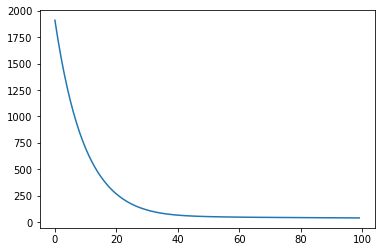

In [17]:
result['train-rmse-mean'].plot()

## hyperparameter tuning in xgboost

In [19]:
gridsearch_params = [ 
    (max_depth, min_child_weight,learning_rate,subsample,colsample_bytree)
    for max_depth in range(3,12)
    for min_child_weight in range(5,10)
    for learning_rate in np.arange(.1,1,.05)
    for subsample in np.arange(.1,1)
    for colsample_bytree in np.arange(.1,1)
]

In [20]:
from tqdm import tqdm

In [22]:
# initial parameter for variable
min_rmse = float('inf')
best_params = None

for max_depth,min_child_weight,lr,ss,colsample_bytree in tqdm(gridsearch_params):
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    params['learning_rate'] = lr
    params['subsample'] = ss 
    params['colsample_bytree'] = colsample_bytree
    result = xgb.cv(dtrain= data_matrix,
                    params= params,
                    nfold = 3,
                    num_boost_round=100,
                    early_stopping_rounds=10,
                    metrics='rmse', # rmse or mse or mae
                    seed = 0 )
    mean_rmse = result['test-rmse-mean'].min()
    boost_rounds = result['test-rmse-mean'].argmin()
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight,lr,ss,colsample_bytree)

        
print(f'Best params: {best_params[0]},{best_params[1]},{best_params[2]},{best_params[3]},{best_params[4]}, with rmse: {min_rmse}')

100%|██████████| 810/810 [02:47<00:00,  4.85it/s]Best params: 3,5,0.20000000000000004,0.1,0.1, with rmse: 92.83525333333334



In [28]:
# updating params with best values
params['max_depth'] = 5
params['min_child_weight'] = 5 
params['learning_rate'] = 0.2
params['subsample'] = 0.1
params['colsample_bytree'] = 0.1
print(params)

{'learning_rate': 0.2, 'max_depth': 5, 'alpha': 10, 'min_child_weight': 5, 'subsample': 0.1, 'colsample_bytree': 0.1}


## Model Training

In [29]:
trainx, testx, trainy, testy = train_test_split(x,y,random_state=0)
dtrain = xgb.DMatrix(data=trainx,label=trainy)
dtest = xgb.DMatrix(data=testx,label=testy)

In [30]:
model = xgb.train(params,dtrain,num_boost_round=100,evals=[(dtest,'Test')],early_stopping_rounds=10)

[0]	Test-rmse:1741.09741
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:1462.91516
[2]	Test-rmse:1204.25415
[3]	Test-rmse:996.86316
[4]	Test-rmse:834.64392
[5]	Test-rmse:730.42926
[6]	Test-rmse:625.55780
[7]	Test-rmse:541.50867
[8]	Test-rmse:460.93140
[9]	Test-rmse:390.59564
[10]	Test-rmse:342.45254
[11]	Test-rmse:309.28787
[12]	Test-rmse:286.16342
[13]	Test-rmse:263.24432
[14]	Test-rmse:235.71609
[15]	Test-rmse:221.60181
[16]	Test-rmse:203.09235
[17]	Test-rmse:191.47734
[18]	Test-rmse:174.02914
[19]	Test-rmse:166.57967
[20]	Test-rmse:158.08659
[21]	Test-rmse:150.44203
[22]	Test-rmse:142.17383
[23]	Test-rmse:132.65674
[24]	Test-rmse:127.40320
[25]	Test-rmse:122.77722
[26]	Test-rmse:117.13808
[27]	Test-rmse:112.29698
[28]	Test-rmse:108.73393
[29]	Test-rmse:107.00161
[30]	Test-rmse:105.51369
[31]	Test-rmse:102.73065
[32]	Test-rmse:103.06565
[33]	Test-rmse:99.94811
[34]	Test-rmse:99.34106
[35]	Test-rmse:98.82185
[36]	Test-rmse:98.45079
[37]	Test-rmse:98.27782
[38]	

## Model Saving

In [31]:
num_round = model.best_iteration+1
best_model = xgb.train(params,dtrain,num_boost_round=num_round,evals=[(dtest,'Test')])

[0]	Test-rmse:1741.09741
[1]	Test-rmse:1462.91516
[2]	Test-rmse:1204.25415
[3]	Test-rmse:996.86316
[4]	Test-rmse:834.64392
[5]	Test-rmse:730.42926
[6]	Test-rmse:625.55780
[7]	Test-rmse:541.50867
[8]	Test-rmse:460.93140
[9]	Test-rmse:390.59564
[10]	Test-rmse:342.45254
[11]	Test-rmse:309.28787
[12]	Test-rmse:286.16342
[13]	Test-rmse:263.24432
[14]	Test-rmse:235.71609
[15]	Test-rmse:221.60181
[16]	Test-rmse:203.09235
[17]	Test-rmse:191.47734
[18]	Test-rmse:174.02914
[19]	Test-rmse:166.57967
[20]	Test-rmse:158.08659
[21]	Test-rmse:150.44203
[22]	Test-rmse:142.17383
[23]	Test-rmse:132.65674
[24]	Test-rmse:127.40320
[25]	Test-rmse:122.77722
[26]	Test-rmse:117.13808
[27]	Test-rmse:112.29698
[28]	Test-rmse:108.73393
[29]	Test-rmse:107.00161
[30]	Test-rmse:105.51369
[31]	Test-rmse:102.73065
[32]	Test-rmse:103.06565
[33]	Test-rmse:99.94811
[34]	Test-rmse:99.34106
[35]	Test-rmse:98.82185
[36]	Test-rmse:98.45079
[37]	Test-rmse:98.27782
[38]	Test-rmse:97.24842
[39]	Test-rmse:96.32455
[40]	Test-rmse

In [32]:
ypred = best_model.predict(dtest)
np.sqrt(mean_squared_error(testy,ypred))

85.48791876095883

In [33]:
best_model.save_model('boston_pricing.model')

In [34]:
loaded_model = xgb.Booster()
loaded_model.load_model('boston_pricing.model')

In [35]:
loaded_model.predict(dtest)

array([1951.465   , 3066.4976  , 1886.4089  , 2932.382   , 1408.0193  ,
       1601.1322  , 1350.9154  , 1530.5421  , 1402.7225  , 2533.7434  ,
       2311.8325  , 2177.3005  , 1769.5425  , 1519.4037  ,  -10.159842,
       2045.697   ,  950.8535  , 2898.8506  , 2097.4097  , 2378.7654  ,
       1587.1656  , 1087.0935  , 2360.6436  , 1567.4264  , 2157.8613  ,
       2014.9226  , 1973.8412  , 2939.609   ,  855.13245 , 1905.1493  ,
       1133.3324  , 2549.0378  , 2238.2004  , 1474.0154  , 1433.6628  ,
       1783.3463  , 1789.4899  , 2663.8547  , 3179.2102  , 1622.9447  ,
        540.8357  , 2412.0796  , 2666.2395  , 2731.7217  , 2058.5417  ,
       1848.2297  , 2038.9736  , 1143.0326  , 1566.8143  , 1597.6603  ,
       1855.4606  , 2128.3389  , 1843.4006  , 2042.7941  , 2277.9568  ,
        296.46368 , 1886.4473  , 1872.9106  ,  482.25296 , 1600.1772  ,
       1299.0994  , 2392.6382  , 2137.1597  , 2023.3911  , 1491.5579  ,
       2421.688   , 2371.0222  , 2329.953   , 1979.4484  , 1801.